In [1]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, auc_score, recall_at_k
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [2]:
data_root = "../data/ml-1m/"

In [3]:
ratings = pd.read_csv(
    data_root+"ratings.dat", 
    sep='::', 
    names=["userID", "movieID", "Rating", "Timestamp"], 
    engine='python'
)
ratings = ratings.sort_values(["userID", "Timestamp"])
ratings

,userID,movieID,Rating,Timestamp
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [4]:
users = pd.read_csv(
    data_root+"users.dat", 
    sep='::', 
    names=["userID", "Gender", "Age", "Occ", "Zip"], 
    engine='python'
)
users

,userID,Gender,Age,Occ,Zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [5]:
from collections import Counter

users[users["Occ"] == 9], users[users["Age"] >= 56]

(      userID Gender  Age  Occ    Zip
 5          6      F   50    9  55117
 36        37      F   25    9  66212
 88        89      F   56    9  85749
 122      123      M   35    9  67208
 125      126      M   18    9  98117
 ...      ...    ...  ...  ...    ...
 5634    5635      F   35    9  06854
 5682    5683      F   18    9  94538
 5861    5862      F   25    9  76120
 5965    5966      F   35    9  10021
 6014    6015      F   25    9  80013
 
 [92 rows x 5 columns],
       userID Gender  Age  Occ    Zip
 1          2      M   56   16  70072
 30        31      M   56    7  06840
 79        80      M   56    1  49327
 88        89      F   56    9  85749
 89        90      M   56   13  85749
 ...      ...    ...  ...  ...    ...
 5947    5948      M   56   13  12124
 5967    5968      M   56    7  98103
 5979    5980      M   56    1  42503
 5985    5986      F   56    1  01060
 6037    6038      F   56    1  14706
 
 [380 rows x 5 columns])

In [6]:
movies = ratings["movieID"].tolist()
len(set(movies)), max(movies), min(movies)

(3706, 3952, 1)

In [7]:
movieIDtosysID = {}
sysIDtomovieID = {}

len(movies)
curr_id = 0
for movie in movies:
    if movie not in movieIDtosysID:
        movieIDtosysID[movie] = curr_id
        sysIDtomovieID[curr_id] = movie
        curr_id += 1

In [8]:
new_movie_id_col = [movieIDtosysID[m] for m in movies]
ratings["movieID"] = new_movie_id_col
new_movies = ratings["movieID"].tolist()
len(set(new_movies)), max(new_movies), min(new_movies)

(3706, 3705, 0)

In [9]:
no_movies = len(set(new_movies))

In [10]:
no_test_items = 5

In [40]:
userIDtosysID = {}
sysIDtouserID = {}

userID_list = users["userID"].tolist()

no_ratings = 0

train_data = dict()
test_data = dict()

group_info = []

no_users = 0

for u_id in userID_list:
    user_ratings = ratings[(ratings["userID"] == u_id) & (ratings["Rating"] >= 5)]
    
    if len(user_ratings) < 15:
        continue
        
    user_items = user_ratings["movieID"].tolist()
    user_prof = users[users["userID"] == u_id]
    user_g = np.zeros(4).astype("int")
    gender = user_prof["Gender"].item()
    age = user_prof["Age"].item()
    if gender == "M":
        user_g[0] = 1
    else:
        user_g[1] = 1
    if age > 55 and gender == "M":
        user_g[2] = 1
    else:
        user_g[3] = 1
    
    group_info.append(user_g)
    
    train_data[no_users] = user_items[:-no_test_items]
    test_data[no_users] = user_items[-no_test_items:]
        
    userIDtosysID[u_id] = no_users
    sysIDtouserID[no_users] = u_id
        
    no_users += 1
    
group_info = np.vstack(group_info)

In [41]:
group_info.shape, no_movies, no_users

((4050, 4), 3706, 4050)

In [42]:
group_info.sum(0)

array([2968, 1082,  145, 3905])

In [43]:
torch.save(torch.Tensor(group_info), "../data/ml-1m/group_info.pt")

In [15]:
import scipy.sparse as sp

def build_interaction_matrix(data, rows, cols):

    mat = sp.lil_matrix((rows, cols), dtype=np.int32)

    for uid, v in data.items():
        for mid in v: 
            mat[uid, mid] = 1.0

    return mat.tocoo()

train_mat = build_interaction_matrix(train_data, no_users, no_movies)
test_mat = build_interaction_matrix(test_data, no_users, no_movies)

In [16]:
test_mat.shape

(4050, 3706)

In [17]:
# Instantiate and train the model
model = LightFM(loss='warp', no_components=16)
model.fit(train_mat, epochs=30, num_threads=2)

In [18]:
# Evaluate the trained model
test_precision = precision_at_k(model, test_mat, k=5, preserve_rows=True)
test_precision.mean()

0.02108642

In [19]:
user_embeds = model.user_embeddings
movie_embeds = model.item_embeddings

user_embeds.shape, movie_embeds.shape

((4050, 16), (3706, 16))

In [20]:
score_mat = user_embeds @ movie_embeds.T
print(np.min(score_mat), np.max(score_mat))
for k, v in train_data.items():
    score_mat[k, v] = np.min(score_mat)

-5.8508434 5.7833843


In [21]:
num_hypotheses = 100
thresholds = torch.linspace(np.min(score_mat), np.max(score_mat), num_hypotheses)

In [22]:
X = torch.Tensor(score_mat)

In [23]:
preds = torch.gt(X.unsqueeze(-1), thresholds).int()

In [24]:
preds.shape

torch.Size([4050, 3706, 100])

In [25]:
gt = test_mat.toarray()
out = preds*np.expand_dims(gt, -1)

In [26]:
r_loss = 1-(out.sum(1)/no_test_items)

In [27]:
p_loss = 1-(out.sum(1)/preds.sum(1))
p_loss = torch.nan_to_num(p_loss)

In [28]:
loss = 0.5*r_loss**2 + 0.5*p_loss**2

In [29]:
mean_per_t = torch.mean(loss, 0)
r_per_t = torch.mean(r_loss, 0)
p_per_t = torch.mean(p_loss, 0)

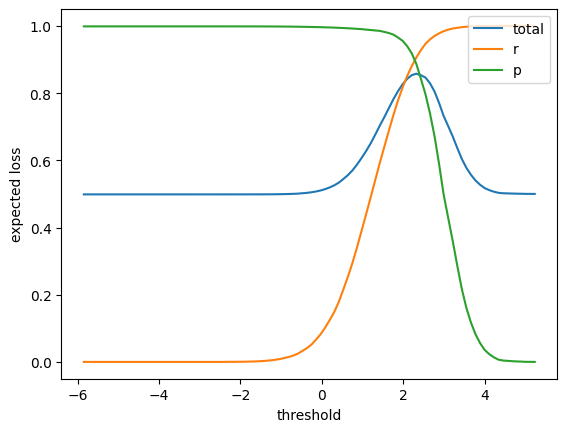

In [30]:
plt.plot(thresholds, mean_per_t, label="total")
plt.plot(thresholds, r_per_t, label="r")
plt.plot(thresholds, p_per_t, label="p")
plt.xlabel("threshold")
plt.ylabel("expected loss")
plt.legend()
plt.show()

In [31]:
torch.save(torch.Tensor(group_info), "../data/ml-1m/group_info.pt")
torch.save(loss, "../data/ml-1m/loss_matrix.pt")